In [55]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy
from astropy.io import fits
from matplotlib import rcParams
from astropy.wcs import WCS 
from pathlib import Path
from reproject import reproject_interp
import sep
#import fitsio
import photutils
from photutils.aperture import CircularAperture, EllipticalAperture, ApertureStats
from photutils.aperture import aperture_photometry
rcParams['figure.figsize'] = [12., 12.]
from scipy.spatial import cKDTree
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table


In [56]:


#https://docs.astropy.org/en/stable/io/fits/index.html
# https://stackoverflow.com/questions/21583647/reading-headers-from-multiple-fits-file-from-the-same-directory
import warnings
from astropy.utils.exceptions import AstropyWarning

warnings.simplefilter('ignore', category=AstropyWarning)



directory = Path(r"C:\Users\FN-2187\StarClusters\Nickel_fits_April13_2023")

fits_files = [f for f in directory.iterdir() if f.suffix.lower() == '.fits']
image_data = []
image_headers = []
records = []

for f in fits_files:
    with fits.open(f) as hdul:
        data = hdul[0].data
        header = hdul[0].header
        wcs = WCS(header)
        image_data.append(data)
        image_headers.append(header)
        records.append((f, data, header, wcs))


In [57]:
#https://stackoverflow.com/questions/21583647/reading-headers-from-multiple-fits-file-from-the-same-directory
#https://www.w3schools.com/python/ref_string_startswith.asp

bias = [
    data for f, data in zip(fits_files, image_data)
    if f.stem.startswith('d') and 100 <= int(f.stem.split('d')[-1]) <= 109
]

domeflatB = [
    data for f, data in zip(fits_files, image_data)
    if f.stem.startswith('d') and 110 <= int(f.stem.split('d')[-1]) <= 114
]

domeflatV = [
    data for f, data in zip(fits_files, image_data)
    if f.stem.startswith('d') and 115 <= int(f.stem.split('d')[-1]) <= 119
]

domeflatR = [
    data for f, data in zip(fits_files, image_data)
    if f.stem.startswith('d') and 120 <= int(f.stem.split('d')[-1]) <= 124
]


In [58]:
rawB = [
    data for f, data in zip(fits_files, image_data)
    if f.stem.startswith('d') and 156 <= int(f.stem.split('d')[-1]) <= 160
]
rawV = [
    data for f, data in zip(fits_files, image_data)
    if f.stem.startswith('d') and 161 <= int(f.stem.split('d')[-1]) <= 165
]
rawR = [
    data for f, data in zip(fits_files, image_data)
    if f.stem.startswith('d') and 166 <= int(f.stem.split('d')[-1]) <= 170  
]

In [59]:
#data type dictates where the party goes
print(type(rawB))

<class 'list'>


In [60]:
master_bias=np.median(np.stack(bias),axis=0)

def domecal(filt, bias):
    clean = [flat - bias for flat in filt] 
    master_dome= np.mean(clean, axis=0)
    return master_dome/np.mean(master_dome)

def scical(sci, flat):
    cleaned_images = []
    for image in sci:
        # Subtract bias
        corrected = image - master_bias

        # Divide by normalized flat
        cleaned = corrected / flat

        cleaned_images.append(cleaned)
    
    return cleaned_images

In [61]:
normdomB=domecal(domeflatB,master_bias)
normdomV=domecal(domeflatV,master_bias)
normdomR=domecal(domeflatR,master_bias)

In [62]:
cleaned_sci_imagesB= scical(rawB, normdomB)
cleaned_sci_imagesV= scical(rawV, normdomV)
cleaned_sci_imagesR= scical(rawR, normdomR)

C:\Users\FN-2187\AppData\Local\Temp\ipykernel_11236\2972619361.py:15: RuntimeWarning: divide by zero encountered in divide
  cleaned = corrected / flat
C:\Users\FN-2187\AppData\Local\Temp\ipykernel_11236\2972619361.py:15: RuntimeWarning: invalid value encountered in divide
  cleaned = corrected / flat


In [63]:
calibB = [data for f, data in zip(fits_files, image_data) if 126 <= int(f.stem.split('d')[-1]) <= 130]
calibV = [data for f, data in zip(fits_files, image_data) if 131 <= int(f.stem.split('d')[-1]) <= 135]
calibR = [data for f, data in zip(fits_files, image_data) if 136 <= int(f.stem.split('d')[-1]) <= 140]

calibB_headers = [header for f, header in zip(fits_files, image_headers) if 126 <= int(f.stem.split('d')[-1]) <= 130]
calibV_headers = [header for f, header in zip(fits_files, image_headers) if 131 <= int(f.stem.split('d')[-1]) <= 135]
calibR_headers = [header for f, header in zip(fits_files, image_headers) if 136 <= int(f.stem.split('d')[-1]) <= 140]


In [64]:
cleaned_standardB= scical(calibB,normdomB)
cleaned_standardR= scical(calibR,normdomR)
cleaned_standardV= scical(calibV,normdomV)

C:\Users\FN-2187\AppData\Local\Temp\ipykernel_11236\2972619361.py:15: RuntimeWarning: invalid value encountered in divide
  cleaned = corrected / flat
C:\Users\FN-2187\AppData\Local\Temp\ipykernel_11236\2972619361.py:15: RuntimeWarning: divide by zero encountered in divide
  cleaned = corrected / flat


In [65]:
 # Clean science frames with only bias correction
# def scical_bias_only(sci, master_bias):
#     cleaned_images = []
#     for image in sci:
#         corrected = (image - master_bias).astype(np.float32)
#         cleaned_images.append(corrected)
#     return cleaned_images



In [66]:
# cleaned_sci_imagesB = bias_only_scical(rawB, normdomB)
# cleaned_sci_imagesV = bias_only_scical(rawV, normdomV)
# cleaned_sci_imagesR = bias_only_scical(rawR, normdomR)

# Key the data

In [67]:
science_images = {
    'B': cleaned_sci_imagesB,
    'V': cleaned_sci_imagesV,
    'R': cleaned_sci_imagesR
}

In [68]:
bias_headers = [
    header for f, header in zip(fits_files, image_headers)
    if f.stem.startswith('d') and 100 <= int(f.stem.split('d')[-1]) <= 109
]
domeflatB_header  = [
    header for f, header in zip(fits_files, image_headers)
    if f.stem.startswith('d') and 110 <= int(f.stem.split('d')[-1]) <= 114
]
domeflatV_header  = [
    header for f, header in zip(fits_files, image_headers)
    if f.stem.startswith('d') and 115 <= int(f.stem.split('d')[-1]) <= 119
]
domeflatR_header  = [
    header for f, header in zip(fits_files, image_headers)
    if f.stem.startswith('d') and 120 <= int(f.stem.split('d')[-1]) <= 124
]
rawB_header = [
    header for f, header in zip(fits_files, image_headers)
    if f.stem.startswith('d') and 156 <= int(f.stem.split('d')[-1]) <= 160
]
rawV_header  = [
    header for f, header in zip(fits_files, image_headers)
    if f.stem.startswith('d') and 161 <= int(f.stem.split('d')[-1]) <= 165
]
rawR_header  = [
    header for f, header in zip(fits_files, image_headers)
    if f.stem.startswith('d') and 166 <= int(f.stem.split('d')[-1]) <= 170
]

In [69]:
#print(image_headers[0])

In [70]:

ref_wcs = WCS(rawB_header[0]) # or rawB_header[0]

def align_stack(cleaned_images, headers):
    aligned = []
    for img, hdr in zip(cleaned_images, headers):
        array, _ = reproject_interp((img, WCS(hdr)), ref_wcs)
        aligned.append(array)
    return np.median(np.stack(aligned), axis=0)

stacked_B = align_stack(cleaned_sci_imagesB, rawB_header)
stacked_V = align_stack(cleaned_sci_imagesV, rawV_header)
stacked_R = align_stack(cleaned_sci_imagesR, rawR_header)

# no header attached
stacked_calibB = np.median(np.stack(cleaned_standardB), axis=0)
stacked_calibV = np.median(np.stack(cleaned_standardB), axis=0)
stacked_calibR = np.median(np.stack(cleaned_standardB), axis=0)





In [71]:
def photometry(data, thresh=3.5, minarea=3, use_elliptical=True, flux_percentile_cut=None):
    import numpy as np
    import sep
    from astropy.table import Table
    from photutils.aperture import CircularAperture, ApertureStats

    # Ensure proper dtype and byte order
    data = np.nan_to_num(data.astype(np.float32))
    if data.dtype.byteorder not in ('=', '|'):
        data = data.astype(data.dtype.newbyteorder('='))

    # Background subtraction
    bkg = sep.Background(data)
    data_sub = data - bkg.back()

    # Source extraction
    objects = sep.extract(data_sub, thresh=thresh, minarea=minarea)
    if len(objects) == 0:
        raise ValueError("No sources found in image.")

    if use_elliptical:
        # Build a mask of valid parameters before unpacking
        ny, nx = data.shape
        valid_mask = (
            (objects['a'] > 0.5) & (objects['b'] > 0.5) &
            (objects['a'] < 100) & (objects['b'] < 100) &
            (objects['x'] - objects['a'] * 2 > 0) & (objects['x'] + objects['a'] * 2 < nx) &
            (objects['y'] - objects['b'] * 2 > 0) & (objects['y'] + objects['b'] * 2 < ny) &
            np.isfinite(objects['x']) & np.isfinite(objects['y']) &
            np.isfinite(objects['a']) & np.isfinite(objects['b']) & np.isfinite(objects['theta'])
        )

        # Filter objects
        filtered = objects[valid_mask]

        if len(filtered) == 0:
            raise ValueError("No valid sources remaining after filtering.")

        x = filtered['x']
        y = filtered['y']
        a = filtered['a'] * 2.0
        b = filtered['b'] * 2.0
        theta = filtered['theta']

        try:
            fluxes, flux_errs, _ = sep.sum_ellipse(
                data_sub, x, y, a, b, theta,
                err=bkg.globalrms, subpix=1
            )
        except Exception as e:
            print("⚠️ Still failing after filtering:")
            for i in range(min(5, len(x))):
                print(f"x={x[i]:.2f}, y={y[i]:.2f}, a={a[i]:.2f}, b={b[i]:.2f}, θ={theta[i]:.2f}")
            raise e

        if flux_percentile_cut is not None:
            threshold = np.nanpercentile(fluxes, flux_percentile_cut)
            keep = fluxes > threshold
            x = x[keep]
            y = y[keep]
            fluxes = fluxes[keep]
            flux_errs = flux_errs[keep]

        phot_table = Table()
        phot_table['xcenter'] = x
        phot_table['ycenter'] = y
        phot_table['aperture_sum'] = fluxes
        phot_table['flux_err'] = flux_errs

    else:
        # Circular fallback
        x = objects['x']
        y = objects['y']
        positions = np.column_stack((x, y))
        apertures = CircularAperture(positions, r=3.0)
        stats = [ApertureStats(data_sub, ap) for ap in apertures]
        fluxes = [s.sum for s in stats]
        flux_errs = [s.sum_err for s in stats]

        phot_table = Table()
        phot_table['xcenter'] = x
        phot_table['ycenter'] = y
        phot_table['aperture_sum'] = fluxes
        phot_table['flux_err'] = flux_errs

    return phot_table, objects


In [72]:
phot_tableB, objectsB= photometry(stacked_B, use_elliptical=True)
phot_tableV, objectsV= photometry(stacked_V, use_elliptical=True)
phot_tableR, objectsR= photometry(stacked_R, use_elliptical=True)

standard_tableB, standard_objB= photometry(stacked_calibB, use_elliptical=True)
standard_tableV, standard_objV= photometry(stacked_calibV, use_elliptical=True)
standard_tableR, standard_objR= photometry(stacked_calibR, use_elliptical=True)


In [73]:
print(len(phot_tableB))
print(phot_tableB['flux_err'][:5])  # should be real values
# bkg = sep.Background(stacked_B)
# data_sub = stacked_B - bkg.back()
print(phot_tableB['flux_err'][:10])



541
     flux_err     
------------------
11.800341934163756
 12.43865256025139
16.218018737654187
11.800341934163756
11.125469069289561
     flux_err     
------------------
11.800341934163756
 12.43865256025139
16.218018737654187
11.800341934163756
11.125469069289561
15.234175930189748
 18.44950325976899
11.800341934163756
10.406923381108074
10.406923381108074


In [74]:
def compute_zeropoint(standard_flux, known_mag, exposure):
    """
    Calculate photometric zeropoint.
    standard_flux: Measured flux from standard star
    known_mag: Catalog magnitude of the standard star (e.g., Johnson B, V, R)
    """
    flux_per_sec = standard_flux / exposure
    return known_mag + 2.5 * np.log10(flux_per_sec)


In [75]:

std_fluxB= standard_tableB['aperture_sum'][0]  # assuming one star is detected
std_fluxV= standard_tableV['aperture_sum'][0] 
std_fluxR= standard_tableR['aperture_sum'][0] 

# Example: known magnitude of standard star in V band
known_mag_B = 13.056
known_mag_V = 13.327
known_mag_R = 13.456

zp_B = compute_zeropoint(std_fluxB, known_mag_B,80)
zp_V = compute_zeropoint(std_fluxV, known_mag_V,80)
zp_R = compute_zeropoint(std_fluxR, known_mag_R,120)


In [76]:
print(standard_tableB.colnames)


['xcenter', 'ycenter', 'aperture_sum', 'flux_err']


In [77]:
def flux_to_mag(flux, zp):
    """
    Convert background-subtracted flux to magnitude using zeropoint.
    """
    return -2.5 * np.log10(flux) + zp


In [78]:
# phot_tableB['mag'] = flux_to_mag(phot_tableB['aperture_sum'], zp_B)
# phot_tableV['mag'] = flux_to_mag(phot_tableV['aperture_sum'], zp_V)
# phot_tableR['mag'] = flux_to_mag(phot_tableR['aperture_sum'], zp_R)


In [79]:
from scipy.spatial import cKDTree
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html
# https://youtu.be/Glp7THUpGow?si=NfE2DVtA2xL9I-CA
# Extract coordinates from photometry tables
coords_B = np.column_stack((phot_tableB['xcenter'], phot_tableB['ycenter']))
coords_V = np.column_stack((phot_tableV['xcenter'], phot_tableV['ycenter']))
coords_R = np.column_stack((phot_tableR['xcenter'], phot_tableR['ycenter']))

# Build KD-trees
tree_V = cKDTree(coords_V)
tree_R = cKDTree(coords_R)

# Match B to V and B to R
max_sep = 3.0  # pixel distance tolerance for matching

dist_BV, idx_BV = tree_V.query(coords_B, distance_upper_bound=max_sep)
dist_BR, idx_BR = tree_R.query(coords_B, distance_upper_bound=max_sep)

# Only keep good matches (where distance is below threshold)
valid_BV = dist_BV < max_sep
valid_BR = dist_BR < max_sep
valid_all = valid_BV & valid_BR

# Final matched indices
idx_B = np.where(valid_all)[0]
idx_V = idx_BV[valid_all]
idx_R = idx_BR[valid_all]


In [80]:
matched_B = phot_tableB[idx_B]
matched_V = phot_tableV[idx_V]
matched_R = phot_tableR[idx_R]

combined_catalog = pd.DataFrame({
    'x': matched_B['xcenter'],
    'y': matched_B['ycenter'],
    'flux_B': matched_B['aperture_sum'],
    'flux_V': matched_V['aperture_sum'],
    'flux_R': matched_R['aperture_sum'],
    
    # ADD THESE:
    'flux_err_B': matched_B['flux_err'],
    'flux_err_V': matched_V['flux_err'],
    'flux_err_R': matched_R['flux_err']
})




In [81]:
combined_catalog['flux_err_B'] = matched_B['flux_err'].data
combined_catalog['flux_err_V'] = matched_V['flux_err'].data
combined_catalog['flux_err_R'] = matched_R['flux_err'].data



print(matched_B['flux_err'][:5])


     flux_err     
------------------
 12.43865256025139
 12.43865256025139
 53.06510539673507
 37.52269587041023
27.251722368876294


In [82]:
print(combined_catalog[['flux_B', 'flux_err_B']].describe())


             flux_B  flux_err_B
count  4.100000e+01   41.000000
mean   7.411227e+04   34.600218
std    2.454599e+05   24.772518
min    4.449563e+01    9.634939
25%    7.413041e+01   12.438653
50%    2.494762e+02   26.091538
75%    1.408956e+03   53.500668
max    1.460453e+06   86.356863


In [83]:
print(matched_B['flux_err'][:10])
print(type(matched_B['flux_err']))


     flux_err     
------------------
 12.43865256025139
 12.43865256025139
 53.06510539673507
 37.52269587041023
27.251722368876294
11.800341934163756
 9.634938843022775
 18.02532004655567
21.900507763415217
  62.0687516397321
<class 'astropy.table.column.Column'>


In [84]:
# Exposure times (in seconds)
exp_B = 120
exp_V = 120
exp_R = 60

valid_flux_mask = (
    (combined_catalog['flux_B'] > 0) &
    (combined_catalog['flux_V'] > 0) &
    (combined_catalog['flux_R'] > 0)
)
clean_catalog = combined_catalog[valid_flux_mask]


In [85]:
print(clean_catalog.columns)
print(len(combined_catalog))

Index(['x', 'y', 'flux_B', 'flux_V', 'flux_R', 'flux_err_B', 'flux_err_V',
       'flux_err_R'],
      dtype='object')
41


In [86]:
clean_catalog['flux_B'] /= exp_B
clean_catalog['flux_V'] /= exp_V
clean_catalog['flux_R'] /= exp_R

clean_catalog['flux_err_B'] /= exp_B
clean_catalog['flux_err_V'] /= exp_V
clean_catalog['flux_err_R'] /= exp_R


# error Prop

In [87]:
def flux_to_mag_err(flux, flux_err):
    return 1.0857 * (flux_err / flux)

# Compute magnitude errors
clean_catalog['mag_err_B'] = flux_to_mag_err(clean_catalog['flux_B'], clean_catalog['flux_err_B'])
clean_catalog['mag_err_V'] = flux_to_mag_err(clean_catalog['flux_V'], clean_catalog['flux_err_V'])
clean_catalog['mag_err_R'] = flux_to_mag_err(clean_catalog['flux_R'], clean_catalog['flux_err_R'])



# SNR

In [88]:
# Calculate SNR for each band
clean_catalog['snr_B'] = clean_catalog['flux_B'] / clean_catalog['flux_err_B']
clean_catalog['snr_V'] = clean_catalog['flux_V'] / clean_catalog['flux_err_V']
clean_catalog['snr_R'] = clean_catalog['flux_R'] / clean_catalog['flux_err_R']

# Filter on SNR *before* computing magnitudes
clean_catalog = clean_catalog[
    (clean_catalog['snr_B'] > 3) &
    (clean_catalog['snr_V'] > 3) &
    (clean_catalog['snr_R'] > 3)
]
print(len(clean_catalog))

41


In [89]:

clean_catalog['mag_B'] = flux_to_mag(clean_catalog['flux_B'], zp_B)
clean_catalog['mag_V'] = flux_to_mag(clean_catalog['flux_V'], zp_V)
clean_catalog['mag_R'] = flux_to_mag(clean_catalog['flux_R'], zp_R)



In [90]:
print(clean_catalog[['flux_err_B', 'flux_err_V', 'flux_err_R']].describe())
print((combined_catalog['flux_B'] <= 0).sum(), "B band <= 0")
print((combined_catalog['flux_V'] <= 0).sum(), "V band <= 0")
print((combined_catalog['flux_R'] <= 0).sum(), "R band <= 0")



       flux_err_B  flux_err_V  flux_err_R
count   41.000000   41.000000   41.000000
mean     0.288335    0.456763    0.791391
std      0.206438    0.278505    0.500363
min      0.080291    0.116456    0.188522
25%      0.103655    0.174684    0.266610
50%      0.217429    0.460332    0.806153
75%      0.445839    0.688962    1.215512
max      0.719641    0.980411    1.723418
0 B band <= 0
0 V band <= 0
0 R band <= 0


In [91]:
print("Initial matched sources:", len(combined_catalog))
print("After valid flux filter:", len(clean_catalog))

clean_catalog['snr_B'] = clean_catalog['flux_B'] / clean_catalog['flux_err_B']
clean_catalog['snr_V'] = clean_catalog['flux_V'] / clean_catalog['flux_err_V']
clean_catalog['snr_R'] = clean_catalog['flux_R'] / clean_catalog['flux_err_R']

clean_catalog = clean_catalog[
    (clean_catalog['snr_B'] > 5) &
    (clean_catalog['snr_V'] > 5) &
    (clean_catalog['snr_R'] > 5)
]


print("SNR > 3 in all bands:", len(clean_catalog))



Initial matched sources: 41
After valid flux filter: 41
SNR > 3 in all bands: 30


In [92]:
# --- Step 3: Apply extinction correction ---
k_B, k_V, k_R = 0.25, 0.15, 0.10
A_V = 0.20
A_B = 1.32 * A_V
A_R = 0.81 * A_V

X_B = np.mean([hdr['AIRMASS'] for hdr in rawB_header])
X_V = np.mean([hdr['AIRMASS'] for hdr in rawV_header])
X_R = np.mean([hdr['AIRMASS'] for hdr in rawR_header])

m_atm_ext_B = k_B * X_B
m_atm_ext_V = k_V * X_V
m_atm_ext_R = k_R * X_R


In [93]:
clean_catalog['mag_B_corr'] = clean_catalog['mag_B'] - m_atm_ext_B - A_B
clean_catalog['mag_V_corr'] = clean_catalog['mag_V'] - m_atm_ext_V - A_V
clean_catalog['mag_R_corr'] = clean_catalog['mag_R'] - m_atm_ext_R - A_R


In [94]:
clean_catalog['B-V_corr'] = clean_catalog['mag_B_corr'] - clean_catalog['mag_V_corr']
clean_catalog['V-R_corr'] = clean_catalog['mag_V_corr'] - clean_catalog['mag_R_corr']


In [95]:
print(len(clean_catalog['B-V_corr']))

30


In [96]:
clean_catalog['B-V_err'] = np.sqrt(clean_catalog['mag_err_B']**2 + clean_catalog['mag_err_V']**2)


<ErrorbarContainer object of 3 artists>

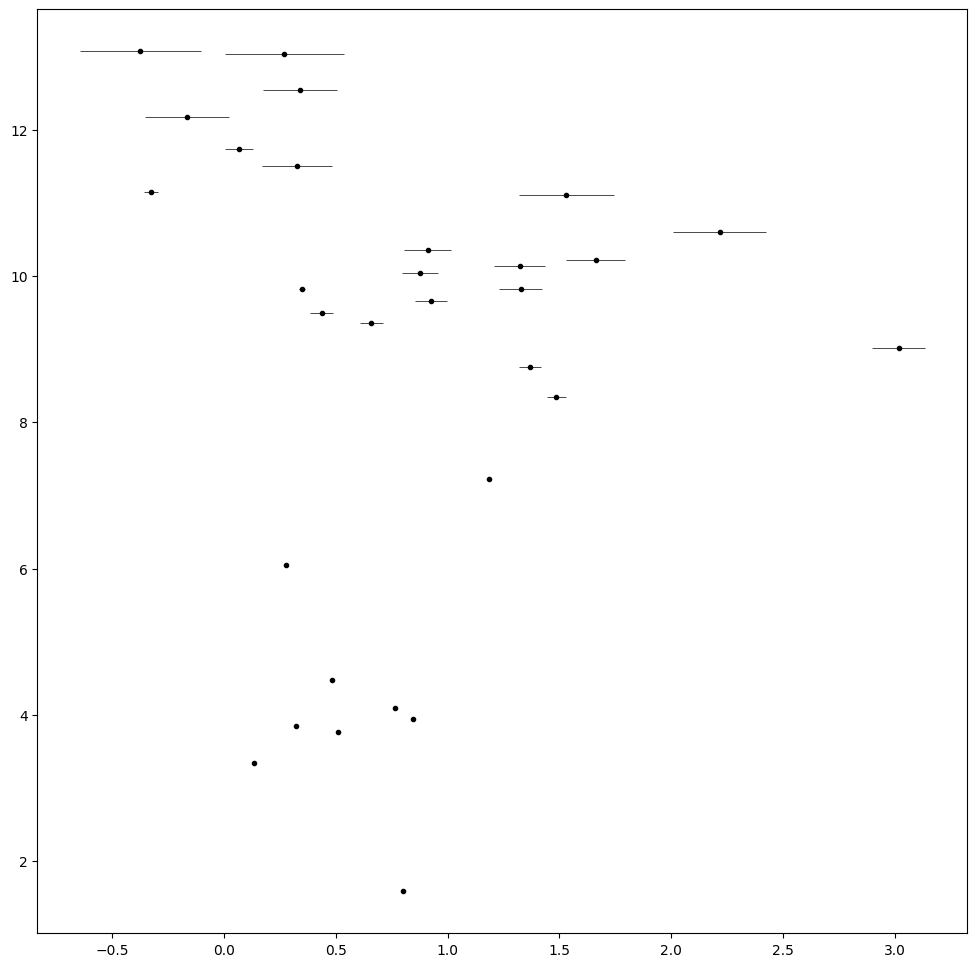

In [97]:
plt.errorbar(
    clean_catalog['B-V_corr'],
    clean_catalog['mag_V_corr'],
    xerr=clean_catalog['B-V_err'],
    fmt='o', color='black', ms=3, elinewidth=0.5
)


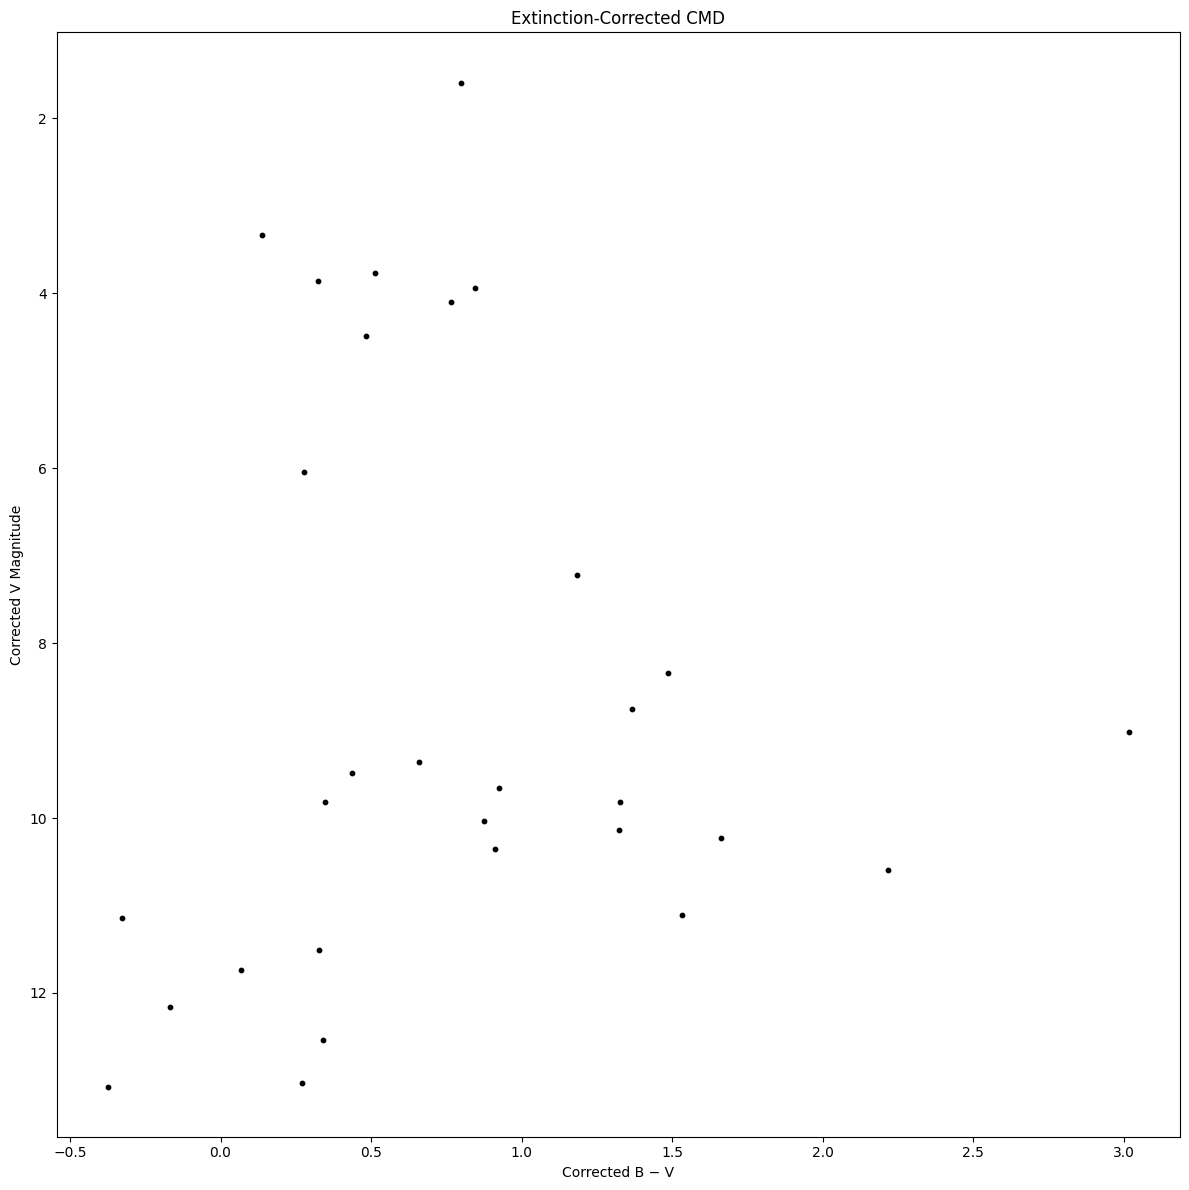

In [98]:


plt.figure()
plt.scatter(clean_catalog['B-V_corr'], clean_catalog['mag_V_corr'], s=10, c='k')
plt.gca().invert_yaxis()
plt.xlabel('Corrected B − V')
plt.ylabel('Corrected V Magnitude')
plt.title('Extinction-Corrected CMD')
plt.tight_layout()
plt.show()



(array([2., 1., 0., 1., 1., 2., 4., 3., 0., 1., 3., 3., 0., 1., 0., 3., 2.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]),
 array([-0.37385939, -0.26083438, -0.14780937, -0.03478436,  0.07824065,
         0.19126566,  0.30429067,  0.41731568,  0.53034069,  0.6433657 ,
         0.75639071,  0.86941572,  0.98244073,  1.09546574,  1.20849075,
         1.32151576,  1.43454077,  1.54756578,  1.66059079,  1.7736158 ,
         1.88664081,  1.99966582,  2.11269083,  2.22571584,  2.33874085,
         2.45176586,  2.56479087,  2.67781588,  2.79084089,  2.9038659 ,
         3.01689091]),
 <BarContainer object of 30 artists>)

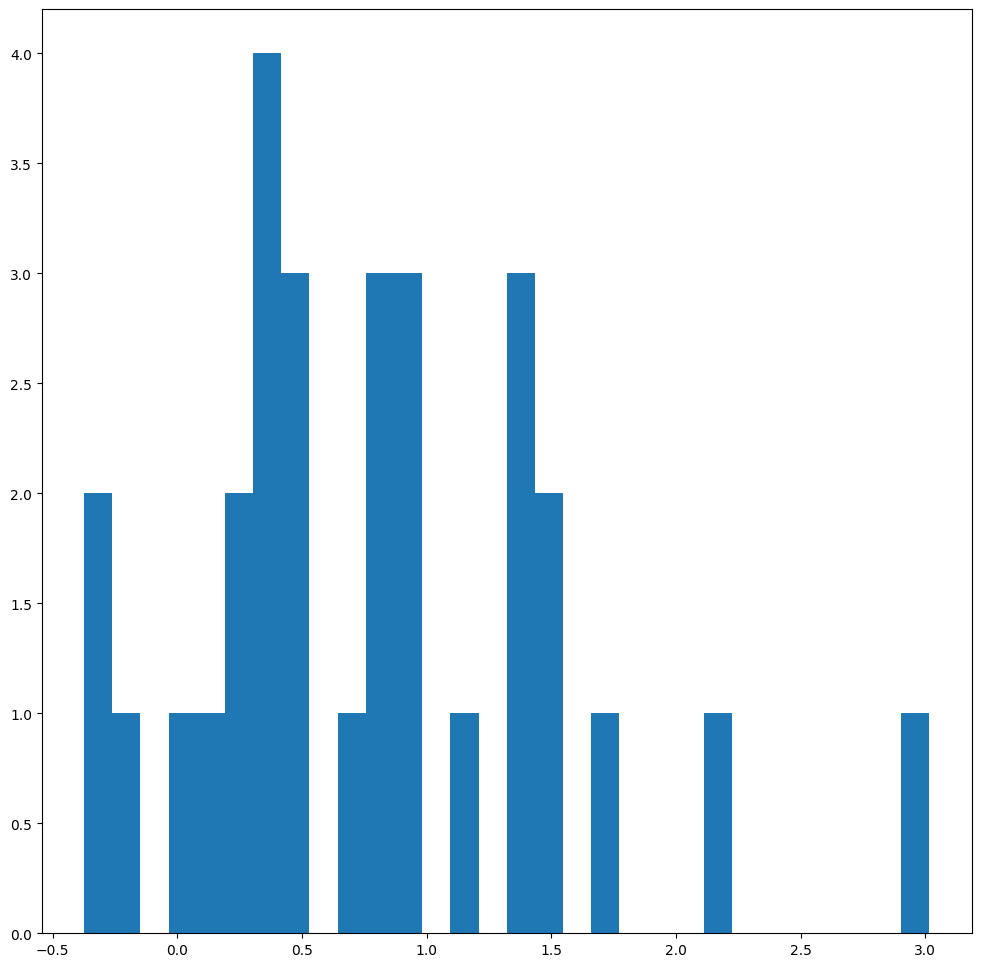

In [99]:
plt.hist(clean_catalog['B-V_corr'], bins=30)


In [100]:

import gzip

isochrone_file = 'isoc_z019.dat.gz'

# Read gzipped isochrone file
with gzip.open(isochrone_file, 'rt') as f:
    lines = f.readlines()

# Extract only the rows containing actual data (skip headers)
data_lines = [line for line in lines if not line.startswith('#') and len(line.strip().split()) > 5]

# Convert to DataFrame
columns = ['Z', 'logAge', 'Mini', 'Mass', 'Teff', 'logL', 'logg', 'Mbol', 'UBmag', 'Bmag', 'Vmag', 'Rmag', 'Imag', 'Jmag', 'Hmag', 'Kmag']
iso_data = pd.DataFrame([list(map(float, line.strip().split())) for line in data_lines], columns=columns)
print("Available log(Age) range:", iso_data['logAge'].min(), "to", iso_data['logAge'].max())
print("Sample rows:\n", iso_data.head())

Available log(Age) range: 0.15000001 to 66.55690765
Sample rows:
      Z  logAge  Mini    Mass    Teff    logL    logg    Mbol   UBmag    Bmag  \
0  6.6    0.15  0.15 -2.5111  3.5183  5.1444  11.048  16.097  14.565  12.988   
1  6.6    0.20  0.20 -2.2373  3.5399  5.0819  10.363  14.929  13.517  12.016   
2  6.6    0.25  0.25 -2.0502  3.5514  5.0377   9.895  14.236  12.873  11.408   
3  6.6    0.30  0.30 -1.9017  3.5605  5.0048   9.524  13.730  12.388  10.938   
4  6.6    0.35  0.35 -1.7732  3.5691  4.9776   9.203  13.297  11.969  10.530   

     Vmag    Rmag   Imag   Jmag   Hmag      Kmag  
0  11.915  10.477  9.200  8.643  8.392 -9.592747  
1  11.018   9.740  8.568  7.996  7.757 -6.505426  
2  10.445   9.254  8.130  7.543  7.310 -4.813348  
3  10.002   8.902  7.787  7.166  6.942 -3.763159  
4   9.618   8.602  7.490  6.839  6.622 -3.056148  


In [101]:
# Parameters
E_BV = 0.0155
A_V = 3.1 * E_BV  # Extinction in V band
distance_modulus = 15.5  # Provided earlier

# Optional: extinction in B band (roughly A_B ≈ 4.1 * E(B-V) for Johnson filters)
A_B = 4.1 * E_BV


In [102]:
log_age_target = 7.499
iso_subset = iso_data[np.isclose(iso_data['logAge'], log_age_target, atol=0.01)].copy()


In [103]:
# Corrected color and magnitude
iso_subset['B-V_corr'] = iso_subset['Bmag'] - iso_subset['Vmag'] - E_BV
iso_subset['V_corr'] = iso_subset['Vmag'] + distance_modulus + A_V



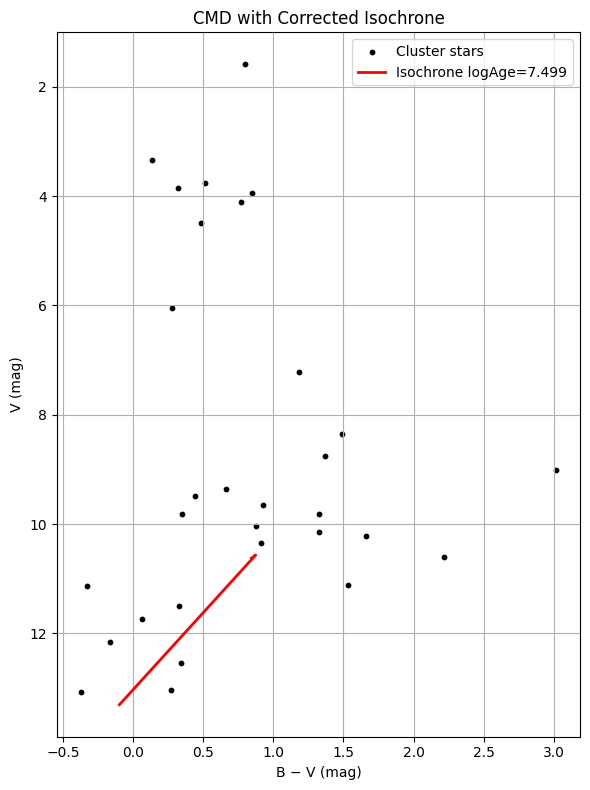

In [104]:

plt.figure(figsize=(6, 8))
plt.scatter(clean_catalog['B-V_corr'], clean_catalog['mag_V_corr'], s=10, color='black', label='Cluster stars')
plt.plot(iso_subset['B-V_corr'], iso_subset['V_corr'], color='red', linewidth=2, label=f"Isochrone logAge={log_age_target}")
plt.gca().invert_yaxis()
plt.xlabel('B − V (mag)')
plt.ylabel('V (mag)')
plt.title('CMD with Corrected Isochrone')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('CMD with Isochrone.png')
plt.show()




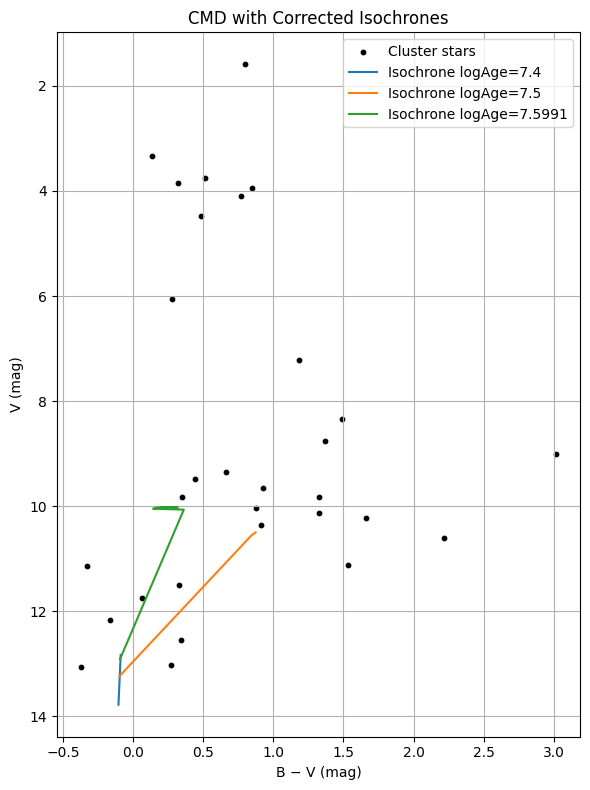

In [105]:
distance_modulus = 15.48

plt.figure(figsize=(6, 8))
plt.scatter(clean_catalog['B-V_corr'], clean_catalog['mag_V_corr'], s=10, color='black', label='Cluster stars')

# Overlay isochrones
for log_age in [7.4, 7.5, 7.5991]:
    iso_subset = iso_data[np.isclose(iso_data['logAge'], log_age, atol=0.01)]
    iso_subset = iso_subset.drop_duplicates(subset=['Bmag', 'Vmag']).sort_values('Vmag')

    # Correct the isochrone magnitudes and colors
    iso_BV = iso_subset['Bmag'] - iso_subset['Vmag'] - E_BV
    iso_V = iso_subset['Vmag'] + distance_modulus

    plt.plot(iso_BV, iso_V, lw=1.5, label=f'Isochrone logAge={log_age}')

# Finalize plot
plt.gca().invert_yaxis()
plt.xlabel('B − V (mag)')
plt.ylabel('V (mag)')
plt.title('CMD with Corrected Isochrones')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('CMD_with_Isochrones.png')
plt.show()






In [106]:
iso_data.to_csv("iso_data_subset.csv", index=False)
